The notebook provides the code to create the self-plagiarism training set, and to train and save the random forest used to identify PPPs (patent-paper-pairs)

# Packages

In [1]:
## import packages 

import pandas as pd 
import psycopg2
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
import unicodedata
from metaphone import doublemetaphone
from fuzzywuzzy import fuzz
from difflib import SequenceMatcher
import requests
import re
import datetime 
from datetime import date
import numpy as np
#from sentence_transformers import SentenceTransformer, util
#model = SentenceTransformer('all-MiniLM-L6-v2')

from multiprocessing import Pool
from functools import partial

import diff_match_patch as dmp_module
from nltk.corpus import stopwords
import datetime 

dmp = dmp_module.diff_match_patch()
stop_words = set(stopwords.words('english'))



/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [72]:
## import database username and password
main_path = "/home/fs01/spec1142/Emma/"

f = open(main_path + "PPPs/database.txt", "r")
user , password = f.read().split()

# Generating training set

## Create first names / last names frequency files

In [74]:
##name cleaning - elements to remove or merge from the names 
name_del = ["2nd", "3rd", "jr", "jr.", "junior", "sr", "sr.", "senior", "i", 'ii' , 'iii']

ln_suff= ["oster", "nordre", "vaster", "aust", "vesle", "da", "van t", "af", "al", "setya", "zu", "la", "na", "mic", "ofver", "el", "vetle", "van het", "dos", "ui", "vest", "ab", "vste", "nord", "van der", "bin", "ibn", "war", "fitz", "alam", "di", "erch", "fetch", "nga", "ka", "soder", "lille", "upp", "ua", "te", "ni", "bint", "von und zu", "vast", "vestre", "over", "syd", "mac", "nin", "nic", "putri", "bet", "verch", "norr", "bath", "della", "van", "ben", "du", "stor", "das", "neder", "abu", "degli", "vre", "ait", "ny", "opp", "pour", "kil", "der", "oz",  "von", "at", "nedre", "van den", "setia", "ap", "gil", "myljom", "van de", "stre", "dele", "mck", "de", "mellom", "mhic", "binti", "ath", "binte", "snder", "sre", "ned", "ter", "bar", "le", "mala", "ost", "syndre", "sr", "bat", "sndre", "austre", "putra", "putera", "av", "lu", "vetch", "ver", "puteri", "mc", "tre", "st"]




In [75]:
#suppress all the unwanted suffixes from a string. 
#name_del file can be modified if more or less suffixes want to be suppressed 

def name_delete(string):
    for elmt in name_del:
        if f" {elmt}" in string:
            return string.replace(f" {elmt}","")
    return string

In [76]:
#merge the nobiliary particles with the last name
#ln_suff file can be modified if more or less nobiliary particles want to be suppressed

    
def ln_suff_merge(string):
    for suff in ln_suff:
        if f" {suff} " in string or string.startswith(f"{suff} "):
            return string.replace(f"{suff} ",suff.replace(" ",""))
    return string

In [77]:
#normalize a string dat that represents often a name. 

def normalize(data):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    # delete unwanted elmt
    val = name_delete(val)
    # Lower case
    val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z ]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    # remove trailing spaces
    val = val.strip()
    return val

normalize("PIERRE De BEHRMAN")

'pierre de behrman'

In [78]:
## frequency of the first names 

#establishing the connection
conn = psycopg2.connect("user=" + user + " password=" + password)

#Creating a cursor object using the cursor() method
cursor = conn.cursor()


#Creating table as per requirement
sql ="""SELECT COUNT(*), disambig_inventor_name_first
        FROM  inventors_PatentsView 
        GROUP BY disambig_inventor_name_first;"""

cursor.execute(sql)
result = cursor.fetchall()


#Closing the connection
conn.close()


dic_first_names = {} 

## count the number of occurences of each name in PV
for elem in tqdm(result):
    value , name = elem 
    if name != None:
        norm_name = normalize(name)
        if norm_name != '':
            if norm_name not in dic_first_names:
                dic_first_names[norm_name] = 0 
            dic_first_names[norm_name] += value
            
            
            
dic_first_names = {k: v for k, v in sorted(dic_first_names.items(), key=lambda item: item[1] , reverse = True)}            


## normalize the frequency of the names 
data = list(dic_first_names.values())
v_max = np.log(1+np.max(data))
v_min = np.log(1+np.min(data))

for elem in dic_first_names:
    dic_first_names[elem] = ( np.log(1 + dic_first_names[elem]) - v_min )/ (v_max - v_min)


import json
json = json.dumps(dic_first_names)
f = open(main_path + "PPPs/frequency_first_names.json","w")
f.write(json)
f.close()

100%|███████████████████████████████| 650450/650450 [00:06<00:00, 106779.69it/s]


In [79]:
## frequency of the last names 

#establishing the connection
conn = psycopg2.connect("user=" + user + " password=" + password)

#Creating a cursor object using the cursor() method
cursor = conn.cursor()


#Creating table as per requirement
sql ="""SELECT COUNT(*), disambig_inventor_name_last
        FROM  inventors_PatentsView 
        GROUP BY disambig_inventor_name_last;"""

cursor.execute(sql)
result = cursor.fetchall()


#Closing the connection
conn.close()


dic_last_names = {} 

## count the number of occurences of each name in PV
for elem in tqdm(result):
    value , name = elem 
    if name != None:
        
        norm_name = normalize(name)
        norm_name = " ".join([ elem for elem in norm_name.split(" ") if len(elem) > 1])
        
        if norm_name != '':
            if norm_name not in dic_last_names:
                dic_last_names[norm_name] = 0 
            dic_last_names[norm_name] += value
            
            
dic_last_names = {k: v for k, v in sorted(dic_last_names.items(), key=lambda item: item[1] , reverse = True)}


## normalize the frequency of the names 
data = list(dic_last_names.values())
v_max = np.log(np.max(data))
v_min = np.log(np.min(data))

for elem in dic_last_names:
    dic_last_names[elem] = ( np.log(1 + dic_last_names[elem]) - v_min )/ (v_max - v_min)


import json
json = json.dumps(dic_last_names)
f = open(main_path + "PPPs/frequency_last_names.json","w")
f.write(json)
f.close()

100%|███████████████████████████████| 770215/770215 [00:06<00:00, 113566.56it/s]


## Functions

In [ ]:
## load dictionary with the distribution of the last names: 
f = open(main_path + "PPPs/frequency_last_names.json","r")
import json
dic_last_names = json.load(f)

## load dictionary with the distribution of the first names: 
f = open(main_path + "PPPs/frequency_first_names.json","r")
import json
dic_first_names = json.load(f)

In [74]:
##name cleaning - elements to remove or merge from the names 
name_del = ["2nd", "3rd", "jr", "jr.", "junior", "sr", "sr.", "senior", "i", 'ii' , 'iii']

ln_suff= ["oster", "nordre", "vaster", "aust", "vesle", "da", "van t", "af", "al", "setya", "zu", "la", "na", "mic", "ofver", "el", "vetle", "van het", "dos", "ui", "vest", "ab", "vste", "nord", "van der", "bin", "ibn", "war", "fitz", "alam", "di", "erch", "fetch", "nga", "ka", "soder", "lille", "upp", "ua", "te", "ni", "bint", "von und zu", "vast", "vestre", "over", "syd", "mac", "nin", "nic", "putri", "bet", "verch", "norr", "bath", "della", "van", "ben", "du", "stor", "das", "neder", "abu", "degli", "vre", "ait", "ny", "opp", "pour", "kil", "der", "oz",  "von", "at", "nedre", "van den", "setia", "ap", "gil", "myljom", "van de", "stre", "dele", "mck", "de", "mellom", "mhic", "binti", "ath", "binte", "snder", "sre", "ned", "ter", "bar", "le", "mala", "ost", "syndre", "sr", "bat", "sndre", "austre", "putra", "putera", "av", "lu", "vetch", "ver", "puteri", "mc", "tre", "st"]




In [75]:
#suppress all the unwanted suffixes from a string. 
#name_del file can be modified if more or less suffixes want to be suppressed 

def name_delete(string):
    for elmt in name_del:
        if f" {elmt}" in string:
            return string.replace(f" {elmt}","")
    return string

In [76]:
#merge the nobiliary particles with the last name
#ln_suff file can be modified if more or less nobiliary particles want to be suppressed

    
def ln_suff_merge(string):
    for suff in ln_suff:
        if f" {suff} " in string or string.startswith(f"{suff} "):
            return string.replace(f"{suff} ",suff.replace(" ",""))
    return string

In [77]:
#normalize a string dat that represents often a name. 

def normalize(data):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    # delete unwanted elmt
    val = name_delete(val)
    # Lower case
    val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z ]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    # remove trailing spaces
    val = val.strip()
    return val

normalize("PIERRE De BEHRMAN")

'pierre de behrman'

In [19]:
#return a ratio of similarity of letters between two strings (to handle in the first names errors)

def match_ratio(string1,string2):
    return fuzz.ratio(string1, string2)


In [20]:
#return 4 if string1 and string2 are the same
#return 3 if string1 and string2 sound the same
#otherwise, return less

def metaphone(string1,string2):
    if string1==string2:
        return 4
    tuple1 = doublemetaphone(string1)
    tuple2 = doublemetaphone(string2)
    if tuple1[0] == tuple2[0]:
        return 3
    elif tuple1[0] == tuple2[1] or tuple1[1] == tuple2[0]:
        return 2
    elif tuple1[1] == tuple2[1]:
        return 1
    else:
        return 0

In [21]:
## return 1 if name1 and name2 potentially represent the same individual
## else return 0

def comparison(name1 , name2):
    
    #if there is no first name, retrun it's a match
    if name1 == "" or name2 == "":
        return 1
    
    #if some first names exist:
    list_name1 = name1.split()
    list_name2 = name2.split()
    
    #minimum number of first names to match
    number_match = min( len(list_name1) , len(list_name2))
    
    #for each name, check if there is a match
    count_match = 0
    for elem1 in list_name1:
        match = 0
        
        #if we just have the initial:
        if len(elem1) == 1:
            for elem2 in list_name2:
                if elem1[0] == elem2[0]:
                    match = 1
        else:
            for elem2 in list_name2:
                #if we just have the initial:
                if len(elem2) == 1 and elem1[0] == elem2[0]:
                    match = 1
                    
                #if elem1 and elem2 are entire first names that sound the same and have a ratio of common letters higher thsan 85%, it's a match
                elif len(elem2) > 1 and (metaphone(elem1,elem2) > 2 or match_ratio(elem1 , elem2) > 85 ) :
                    match = 1
                    
        #count the number of first names that match    
        count_match += match
        
    #check if we have enough first names that match 
    if count_match < number_match:
        return 0
    else:
        return 1



In [22]:
# for the strings author and inventor which contain the last name "name"
# quantify the similarity between two author and inventor

def score(author , inventor , name):
    
    score = 0
    
    #get the distribution of the last names (from the dictionary dic_last_names)
    #it's possible to change the distribution of the last names by changing the dictionary
    name = normalize(name)
    if name in dic_last_names:
        dist = dic_last_names[name]
    else:
        dist = 0
    
    
    #remove the last name from the author name
    author_names = normalize(author)
    author_names = author_names.split()
    author_names.remove(name)
    
    #split the two letters strings into two separated initials 
    for elem in author_names:
        if len(elem) == 2:
            author_names += [ elem[0] , elem[1] ] 
            author_names.remove(elem)
            
    #sorte the cleaned author name by the lenght of the first names
    author_names = sorted(author_names , key=len , reverse=True)
    
    #sorte the inventor first name by the lenght of the first names
    inventor_names = normalize(inventor)
    inventor_names = sorted(inventor_names.split(), key=len, reverse=True)
    inventor_names.remove(name)

            
    #if there is not first name, the socre is 0.4
    if author_names == [] or inventor_names == []:
        score = 0.4
        
    #if both author and inventor have an entire first name (not just initial)
    elif len(author_names[0]) > 2 and len(inventor_names[0]) > 2:
        
        #if the first names match:
        if author_names[0] == inventor_names[0]:
            
            #we add the first name distribution to the distribution of the full name
            if author_names[0] in dic_first_names:
                dist = dist*dic_first_names[author_names[0]]
            
            #if a middle name match, the score is 1 
            if len(set(author_names) & set(inventor_names)  ) > 1: 
                score = 1
            
            #if there is no middle name, the score is 0.8
            else:
                score = 0.8
                
        #if the first names don't match:
        else:
            #if the first names sound the same and have more than 85% of letters in common, the score is 0.7
            if (metaphone(author_names[0],inventor_names[0])) > 2 or match_ratio(author_names[0],inventor_names[0]) > 85 :
                score = 0.7
            #else, the scoe is 0.1
            else:
                score = 0.1
    
    #if the author or the inventor only have an initial:
    elif len(author_names[0]) < 3 or len(inventor_names[0]) < 3:
        #if only the first initial of the author matches with the first initial of the inventor, the score is 0.6
        if author_names[0][0] == inventor_names[0][0]:
            score = 0.6
            
            #if more than one initial are matching, the score is 0.8
            if len(author_names) > 1 and len(inventor_names) > 1 and author_names[1][0] == inventor_names[1][0]:
                score = 0.8
        #if only a middle initial matches with am initial, the score is 0.2
        else:
            score = 0.2
    
    #return the similarity between the inventor and author name, the distribution of the matching name, 
    #the author and inventor names and the similarity between the inventor and author name normalize by the distribution of the name. 
    return   score, dist,  author  , inventor , score /(1 + dist)
    


In [23]:
## get number of in common authors

def number_of_in_common_authors(inventors , authors ):
    

    
    #count the number of names in common, and store the names in common
    count = 0
    list_in_common_authors = []

    
    for name_inventor in inventors:
        
        for name_author in authors:
                        
            
            if len(set(name_inventor.split()) & set( name_author.split())) > 0:
            
                match = comparison(name_author , name_inventor)

                #if the first names match, we store the first names that are matching and their index 
                if match == 1:
                    count += 1 
                    list_in_common_authors.append(name_author + "-" + name_inventor)
                    


    #return 1) the number of names in common, 2) the list of names in common, 3) their index 
    return  count ,  list_in_common_authors 


In [24]:
def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text

In [25]:
## calculate efficiently the dot product between two vectors

def norm(vector):
    return sqrt(sum(x * x for x in vector))    

def cosine_similarity2(vec_a, vec_b):
        norm_a = norm(vec_a)
        norm_b = norm(vec_b)
        dot = sum(a * b for a, b in zip(vec_a, vec_b))
        return dot / (norm_a * norm_b)

In [26]:
## calculate efficiently the geographic distance between two points on the earth

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [27]:
## function to calculate the minimal distance between two list of coordinates 

def distance_assignees(coords1 , coords2):
     
    distance = np.inf
    #get minimum geographic distance between the paper and the patent institutions
    for elem1 in coords1:
        if elem1 in coords2:
            return 0
        else:
            for elem2 in coords2:
                dist = haversine(elem1[0], elem1[1], elem2[0], elem2[1])
                if dist < distance:
                    distance = dist
                    
    if distance == np.inf:
        distance = None
                    
    return distance
        

In [28]:
## clean string - remove stop words 

def clean_string_stop_words(text):
    text = normalize(text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

## Patent to paper citations and self plagiarism

In [80]:
## load dictionary with the missing institutions (key: display name, values: city, country, longitude, latitude) 
institutions_file = pd.read_csv(main_path + "PPPs/institutions_up_to_20230817.tsv" , delimiter = "\t", index_col = 0 )
institutions_file = institutions_file[["longitude" , "latitude"]]
dic_institutions = institutions_file.to_dict('index')


In [69]:
## load patent to paper citations from Matt Marx

matt_file = pd.read_csv(main_path + 'PPPs/Matt_and_Fuegi.csv' )
matt_file_self = matt_file[matt_file["self"] > 'isself']


In [70]:
matt_file_self

,oaid,patent,wherefound,confscore,self,reftype
0,1552,us-11426570-b2,front,10,notself,app
1,3066,us-10494607-b2,front,10,notself,app
2,3066,us-7311905-b2,front,10,notself,app
3,3066,us-7700090-b2,front,10,notself,app
4,3066,us-8057789-b2,front,10,notself,app
...,...,...,...,...,...,...
95,37005,us-9950067-b2,front,10,notself,app
96,37355,us-7431242-b1,front,10,notself,app
97,38196,us-10597638-b2,front,10,notself,app
98,38196,us-10898497-b2,front,10,notself,app


In [40]:
citations = matt_file_self[[ "patent" , "oaid" ]].to_numpy()[:10000]


def get_training_set(workers, i):

     """
    This function retrieves and compares the titles and abstracts of patents and papers from a PostgreSQL database to create a training set for a machine learning model.

    Parameters:
    - workers (int): The number of worker processes to use for parallel processing. 
    - i (int): The starting index for the citations to be processed.

    Returns:
    - dic_similarity (dict): A dictionary containing the similarity scores between the titles and abstracts of patents and papers, as well as other relevant information such as publication dates and author names.

    Notes: 
    The function first establishes a connection with a PostgreSQL database using the psycopg2 library. It then retrieves a list of citations to be processed, with each citation consisting of a patent ID and a paper ID. The function loops through the list of citations in batches of size 'workers', with the starting index being 'i'.

    For each citation, the function retrieves the encoded titles and abstracts of the patent and the paper from the PostgreSQL database. If the abstracts of both the patent and the paper are available, the function calculates the cosine similarity between the titles and abstracts of the patent and the paper using the cosine_similarity2() function. The function also retrieves other relevant information such as the publication dates, author names, and assignee names of the patent and the paper.

    The function stores the similarity scores and other relevant information in a dictionary called 'dic_similarity', with the keys being the concatenation of the patent ID and the paper ID.

    The function returns the 'dic_similarity' dictionary, which can be used as a training set for a machine learning model to predict the similarity between patents and papers.
    """

    #establishing the connection with the database 
    conn = psycopg2.connect("user=" + user + " password=" + password) 
    cursor = conn.cursor()
    
    dic_similarity = {}
    
    
    list_index = [ k for k in range(i,len(citations), workers) ] 
    count = 0
        
    for k in list_index:

        elem = citations[k]
        dic_comparison = {}
        dic_comparison["PV"] = {}
        dic_comparison["OA"] = {}
    
        count += 1
        
        dic_similarity1 = {}
        
        ## only select US patents 
        if elem[0][:3] == "us-":
    
            ##compare patent titles/abstacts and papers titles/abstracts 
    
            patent_id = elem[0].split("-")[1]
            dic_comparison["PV"][patent_id] = {}
            
            text = """ SELECT  pe.encoded_title , pe.encoded_abstract
                       FROM encoded_patents_PatentsView AS pe
                       WHERE pe.patent_id = '"""+ patent_id + """';"""
            
            cursor.execute(text)
            res = cursor.fetchall()
    
            
            for line in res:
                if line[0] != 0:
                    dic_comparison["PV"][patent_id]["title"] = clean_encoding(line[0])
                if line[1] != 0:
                    dic_comparison["PV"][patent_id]["abstract"] = clean_encoding(line[1])
                    
                    
                    
            work_id = "W" + str(elem[1])
            dic_comparison["OA"][work_id] = {}
            
            text = """ SELECT  we.encoded_title , we.encoded_abstract 
                        FROM encoded_works_OpenAlex AS we 
                        WHERE we.work_id = '"""+ str(work_id) +"""';"""
    
    
            cursor.execute(text)
            res = cursor.fetchall()
            
            encoded_title_OA = None
            encoded_abstract_OA = None
            for line in res:
    
                if line[0] != None and line[0] != '':
                    dic_comparison["OA"][work_id]["title"] = clean_encoding(line[0])
    
    
                if line[1] != None and line[1] != '':
                    dic_comparison["OA"][work_id]["abstract"] = clean_encoding(line[1])
    
                    
            if  "title" not in dic_comparison["OA"][work_id]:
                dic_comparison["OA"][work_id]["title"]  = None
            if  "abstract" not in dic_comparison["OA"][work_id]:
                dic_comparison["OA"][work_id]["abstract"]  = None
                
    
            ## only keep the paper and patent if an abstract is found 
            if dic_comparison["OA"][work_id]["abstract"] != None and "abstract" in dic_comparison["PV"][patent_id] and dic_comparison["PV"][patent_id]["abstract"] != None:
    
                ## save the similarity between the patent and the paper titles/abstracts 
                dic_similarity1["US-" + patent_id + " " + work_id] = {}
                
        
                encoded_title_PV = dic_comparison["PV"][patent_id]["title"]
                encoded_abstract_PV = dic_comparison["PV"][patent_id]["abstract"]
        
                encoded_title_OA = dic_comparison["OA"][work_id]["title"]
                encoded_abstract_OA = dic_comparison["OA"][work_id]["abstract"]
        
        
                if encoded_title_PV != None and encoded_title_OA != None:
                    dic_similarity1["US-" + patent_id + " " + work_id]["title_similarity"] = cosine_similarity2(encoded_title_PV , encoded_title_OA)
                else:
                    dic_similarity1["US-" + patent_id + " " + work_id]["title_similarity"] = None
        
                if encoded_abstract_OA != None and encoded_abstract_PV != None and encoded_abstract_PV != [] :
                    dic_similarity1["US-" + patent_id + " " + work_id]["abstract_similarity"] = cosine_similarity2(encoded_abstract_PV , encoded_abstract_OA)
                else:
                    dic_similarity1["US-" + patent_id + " " + work_id]["abstract_similarity"] = None
                    
                    
                                   
                ##get other data on the patent     
                text = """ SELECT  p.patent_date , ap.filing_date , string_agg( CONCAT(disambig_inventor_name_first ,  ' '  , disambig_inventor_name_last),  '#') , p.patent_title , p.patent_abstract , string_agg( concat(a.disambig_assignee_organization  , '%' , l.longitude , '%' , l.latitude ) ,   '#') 
                            FROM patents_PatentsView AS p 
                            LEFT JOIN applications_PatentsView AS ap ON ap.patent_id = '"""+ patent_id + """'
                            LEFT JOIN inventors_PatentsView AS i ON i.patent_id =  '"""+ patent_id + """'
                            LEFT JOIN assignees_PatentsView AS a ON a.patent_id =  '"""+ patent_id + """'
                            LEFT JOIN locations_PatentsView AS l ON a.location_id = l.location_id
                            WHERE p.patent_id = '"""+ patent_id + """'
                            GROUP BY  p.patent_date , ap.filing_date , p.patent_title , p.patent_abstract;"""
                            
        
                cursor.execute(text)
                res = cursor.fetchall()
        
                for line in res:
        
                    dic_comparison["PV"][patent_id]["patent_date"] = line[0]
                    dic_comparison["PV"][patent_id]["filing_date"] = line[1]
                    dic_comparison["PV"][patent_id]["co_inventors"] = [ normalize(elem) for elem in set(line[2].split("#")) ] 
                    dic_comparison["PV"][patent_id]["title_abstract"] = line[3] + ". " + line[4]
                    if line[5] != None:
                        locations = [ elem.split("%") for elem in set(line[5].split("#"))] 
                        dic_comparison["PV"][patent_id]["assignees"] = ", ".join([ elem[0].replace("\"" , "") for elem in locations ] )
                        dic_comparison["PV"][patent_id]["coordinates"] = [ (float(elem[1]) , float(elem[2]))for elem in locations if elem[1] != '' and elem[1] != None ]
                    else:
                        dic_comparison["PV"][patent_id]["assignees"] = None
                        dic_comparison["PV"][patent_id]["coordinates"] = []
                
        
                ##get other data on the paper     
                text = """ SELECT  w.title , w.abstract, w.publication_date , w.type , string_agg(a.display_name , '#') , string_agg(wa.institution_name , ', ') , string_agg(wa.institution_id , '#')
                            FROM works_authors_OpenAlex AS wa
                            LEFT JOIN works_OpenAlex AS w ON w.work_id = wa.work_id 
                            LEFT JOIN authors_OpenAlex AS a ON wa.author_id = a.author_id
                            WHERE wa.work_id ='""" + str(work_id) +"""'
                            group by w.title , w.abstract, w.publication_date , w.type ;"""
        
        
        
        
                cursor.execute(text)
                res = cursor.fetchall()
                
                for line in res:
        
                    dic_comparison["OA"][work_id]["publication_date"] = None
                    if line[2] != None:
                        dic_comparison["OA"][work_id]["publication_date"] = line[2]
        
                    if line[3] != None:
                        dic_comparison["OA"][work_id]["type"] = line[3]

                    if line[4] != None:
                        dic_comparison["OA"][work_id]["co_authors"] = [ normalize(elem) for elem in set(line[4].split("#") )] 
                    else:
                         dic_comparison["OA"][work_id]["co_authors"] = []
        
                    if line[0] != None:
                        dic_comparison["OA"][work_id]["title_abstract"] = line[0] + ". " + line[1]
        
                    dic_comparison["OA"][work_id]["institutions"] = line[5]
                    if line[6] != None:
                        inst_ids = line[6].split("#")
                    else:
                        inst_ids = []
                    dic_comparison["OA"][work_id]["coordinates"] = []
                    
                    for inst_id in inst_ids:
                        if inst_id in dic_institutions:
                            dic_comparison["OA"][work_id]["coordinates"].append((dic_institutions[inst_id]["longitude"] , dic_institutions[inst_id]["latitude"]))
                                         
    
                ## if a paper date is found, compare the paper and the patent 
                if "publication_date" in dic_comparison["OA"][work_id] and dic_comparison["OA"][work_id]["publication_date"] != None:
        
                    dic_similarity1["US-" + patent_id + " " + work_id]["difference_patent_app_paper"] =  dic_comparison["PV"][patent_id]["filing_date"] - dic_comparison["OA"][work_id]["publication_date"]
        
                    dic_similarity["US-" + patent_id + " " + work_id] = dic_similarity1["US-" + patent_id + " " + work_id]
        
                    encoded_title_PV = dic_comparison["PV"][patent_id]["title"]
                    encoded_abstract_PV = dic_comparison["PV"][patent_id]["abstract"]
        
                    encoded_title_OA = dic_comparison["OA"][work_id]["title"]
                    encoded_abstract_OA = dic_comparison["OA"][work_id]["abstract"]
        
        
                    if encoded_title_PV != None and encoded_title_OA != None:
                        dic_similarity["US-" + patent_id + " " + work_id]["title_similarity"] = cosine_similarity2(encoded_title_PV , encoded_title_OA)
                    else:
                        dic_similarity["US-" + patent_id + " " + work_id]["title_similarity"] = None
        
                    if encoded_abstract_OA != None and encoded_abstract_PV != None and encoded_abstract_PV != [] :
                        dic_similarity["US-" + patent_id + " " + work_id]["abstract_similarity"] = cosine_similarity2(encoded_abstract_PV , encoded_abstract_OA)
                    else:
                        dic_similarity["US-" + patent_id + " " + work_id]["abstract_similarity"] = None
        
                    dic_similarity["US-" + patent_id + " " + work_id]["difference_patent_grant_paper"] =   dic_comparison["PV"][patent_id]["patent_date"] - dic_comparison["OA"][work_id]["publication_date"]
                    dic_similarity["US-" + patent_id + " " + work_id]["paper type"] = dic_comparison["OA"][work_id]["type"]
                    dic_similarity["US-" + patent_id + " " + work_id]["authors in common"] = number_of_in_common_authors(dic_comparison["PV"][patent_id]["co_inventors"] , dic_comparison["OA"][work_id]["co_authors"])[0]
                    dic_similarity["US-" + patent_id + " " + work_id]["numbers authors"] = len(dic_comparison["OA"][work_id]["co_authors"])
                    dic_similarity["US-" + patent_id+ " " + work_id]["numbers inventors"] = len(dic_comparison["PV"][patent_id]["co_inventors"]) 
        
                    dic_similarity["US-" + patent_id + " " + work_id]["proportion inventors"] = 100*number_of_in_common_authors(dic_comparison["PV"][patent_id]["co_inventors"] , dic_comparison["OA"][work_id]["co_authors"])[0] / len(dic_comparison["PV"][patent_id]["co_inventors"])
                    dic_similarity["US-" + patent_id + " " + work_id]["paper_institution"] = dic_comparison["OA"][work_id]["institutions"]
                    dic_similarity["US-" + patent_id + " " + work_id]["patent_assignee"] = dic_comparison["PV"][patent_id]["assignees"]
                    dic_similarity["US-" + patent_id + " " + work_id]["distance_inst_assignee"] = distance_assignees(dic_comparison["PV"][patent_id]["coordinates"], dic_comparison["OA"][work_id]["coordinates"] )
        
    
                    ## seach for self plagiarism in the paper and patent titles + abstracts 
                    text1 = clean_string_stop_words(dic_comparison["OA"][work_id]["title_abstract"])[:1000]
                    text2 = clean_string_stop_words(dic_comparison["PV"][patent_id]["title_abstract"])[:1000]
        
                    plagiarism  = dmp.diff_main(text1, text2 , True)
        
                    plagiarism = [ elem for elem in plagiarism if elem[0] == 0] 
                    plagiarism = sorted(plagiarism, key = lambda val: len(val[1]) , reverse = True)[:5]
                    
                    dic_similarity["US-" + patent_id + " " + work_id]["common_strings"] = [ elem[1] for elem in plagiarism[:5]]
        
                    dic_similarity["US-" + patent_id + " " + work_id]["plagiarism_group_words_1"] = sum([ len(elem[1].split()) for elem in plagiarism[:1]])
        
                    dic_similarity["US-" + patent_id + " " + work_id]["plagiarism_group_words_3"] = sum([ len(elem[1].split()) for elem in plagiarism[:3]])
        
                    dic_similarity["US-" + patent_id + " " + work_id]["plagiarism_group_words_5"] = sum([ len(elem[1].split()) for elem in plagiarism])
                    
                    dic_similarity["US-" + patent_id + " " + work_id]["plagiarism_percentage"] = 100*dic_similarity["US-" + patent_id+ " " + work_id]["plagiarism_group_words_5"] / ( len(text1.split()) + len(text2.split()) - dic_similarity["US-" + patent_id+ " " + work_id]["plagiarism_group_words_5"] ) 
    
    return dic_similarity


In [41]:
## run the code using multiprocessing
workers = 24

p = Pool(processes=workers)
func = partial(get_training_set,workers)
abstracts = p.map(func, [ i  for i in range(workers)])
p.close()

In [42]:
## concatenate output files
dic_similarity = {}

for dic in abstracts:
    dic_similarity = { **dic_similarity , **dic }
print(len(dic_similarity))

3810


In [44]:
## order data by proportion of plagiarism
table = pd.DataFrame(dic_similarity).T.sort_values("plagiarism_percentage" , ascending = False)
table = table[table["abstract_similarity"].notnull()]
table

,title_similarity,abstract_similarity,difference_patent_app_paper,difference_patent_grant_paper,paper type,authors in common,numbers authors,numbers inventors,proportion inventors,paper_institution,patent_assignee,distance_inst_assignee,common_strings,plagiarism_group_words_1,plagiarism_group_words_3,plagiarism_group_words_5,plagiarism_percentage
US-5254258 W23430159,0.483977,-0.167176,"1355 days, 0:00:00","2118 days, 0:00:00",book-chapter,2,4,2,100.0,None,"Research Corporation Technologies, Inc.",2213.932144,"[chiral , tion , ec, an, s ]",1,3,5,50.0
US-6994859 W11401345,0.878784,0.694784,"831 days, 0:00:00","2959 days, 0:00:00",article,2,3,2,100.0,None,The University of Massachusetts,81.463814,[ hemagglutinin purified type clostridium botu...,6,8,10,47.619048
US-9139624 W11401345,0.884639,0.694784,"4148 days, 0:00:00","6473 days, 0:00:00",article,2,3,2,100.0,None,Bal Ram Singh,3.182557,[ hemagglutinin purified type clostridium botu...,6,8,10,47.619048
US-7531183 W11401345,0.884639,0.694784,"2882 days, 0:00:00","4149 days, 0:00:00",article,2,3,2,100.0,None,The University of Massachusetts,81.463814,[ hemagglutinin purified type clostridium botu...,6,8,10,47.619048
US-8440612 W16612720,0.203474,0.419744,"2788 days, 0:00:00","4212 days, 0:00:00",article,2,3,5,40.0,None,Bayer Intellectual Property GmbH,257.62871,"[s pr, c, o, t, r]",2,4,6,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-7022506 W4654663,0.065085,0.299271,"6643 days, 0:00:00","7673 days, 0:00:00",article,2,2,2,100.0,None,The Trustees of the University of Pennsylvania,None,"[ electric, patient, electr, signal, tive]",1,3,5,1.968504
US-5229500 W35771016,0.355039,0.429262,"1511 days, 0:00:00","2576 days, 0:00:00",article,1,6,6,16.666667,None,"Regeneron Pharmaceuticals, Inc., Max-Planck-Ge...",None,"[ factor , factor , relat, ologic, ation ]",1,3,5,1.908397
US-5438121 W35771016,0.355039,0.429262,"1759 days, 0:00:00","3318 days, 0:00:00",article,1,6,6,16.666667,None,MAX-PLANCK-GESELLSCHAFT ZUR FOERDERUNG DER WIS...,None,"[ factor , factor , relat, ologic, ation ]",1,3,5,1.908397
US-5541948 W21192773,0.2577,0.360305,"2509 days, 0:00:00","3119 days, 0:00:00",article,1,3,4,25.0,None,THE REGENTS OF THE UNIVERSITY OF CALIFORNIA,50.383761,"[ transition , state, tion , tion , ence ]",1,3,5,1.851852


In [49]:
## save data
table.to_csv(main_path + "PPPs/predictive_model/PPP_citations5.tsv" , sep = "\t")

In [56]:
## save "non PPPs" (more than 10 years appart)
table_neg = table[table['difference_patent_app_paper'] > pd.Timedelta(days=365*10)].sample(frac=0.1)
table_neg

,title_similarity,abstract_similarity,difference_patent_app_paper,difference_patent_grant_paper,paper type,authors in common,numbers authors,numbers inventors,proportion inventors,paper_institution,patent_assignee,distance_inst_assignee,common_strings,plagiarism_group_words_1,plagiarism_group_words_3,plagiarism_group_words_5,plagiarism_percentage
US-8105834 W33106619,0.30693,0.393167,"5429 days, 0:00:00","6910 days, 0:00:00",article,1,7,4,25.0,None,University of Pittsburgh—Of The Commonwealth S...,992.132569,"[ transplantation, njection, muscle, tions , ...",1,3,5,2.415459
US-8658784 W3724546,0.317744,0.321093,"4582 days, 0:00:00","5169 days, 0:00:00",book-chapter,1,1,6,16.666667,None,Thermo Fisher Scientific Biosciences Inc.,None,"[fficient , s comp, app, e si, tion]",1,4,7,5.035971
US-7699783 W27543669,0.085892,0.217233,"6740 days, 0:00:00","8510 days, 0:00:00",book-chapter,1,6,5,20.0,None,"Techniscan, Inc.",3.80689,"[forma, n rep, tion , tion , ing ]",1,4,6,4.109589
US-6703050 W34274008,0.212575,0.477857,"4508 days, 0:00:00","6157 days, 0:00:00",article,1,7,3,33.333333,None,The Regents of the University of Michigan,1.266562,"[ treatment , therapy , therap, tion , form]",1,3,5,3.731343
US-9662332 W29324485,0.229212,0.238421,"6839 days, 0:00:00","7515 days, 0:00:00",article,1,8,2,50.0,None,Emory University,None,"[s treatment , nfection , idine , ation , anti]",2,4,6,3.278689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-6645715 W9542495,0.433968,0.456982,"3737 days, 0:00:00","4942 days, 0:00:00",article,1,4,4,25.0,None,"University of Ottawa, University of Tennessee ...",1153.592457,"[ cornea, cornea, tions , ction, e con]",1,3,6,3.076923
US-5814510 W26199858,0.765864,0.685257,"4786 days, 0:00:00","6207 days, 0:00:00",article,1,3,3,33.333333,None,"CORNELL RESEARCH FOUNDATION, INC.",None,"[ canine parvovirus cpv strain , canine parvo...",4,8,10,6.451613
US-6563016 W2182237,0.540353,0.330358,"4834 days, 0:00:00","5976 days, 0:00:00",article,0,3,3,0.0,None,University of Washington,None,"[ amyloid, com, can, co, at]",1,3,5,4.545455
US-9464291 W22055284,0.242383,0.162245,"4510 days, 0:00:00","5992 days, 0:00:00",article,1,8,3,33.333333,None,The University of South Alabama,1358.134622,"[latin, ons , pres, ting, lat]",1,3,5,3.355705


In [ ]:
## save data
table_neg.to_csv(main_path + "PPPs/predictive_model/PPP_negative_training_set.tsv" , sep = "\t")

# PPP: Model and predictions

## Data

In [20]:
## get accuracy metrics to evaluate Machine Learning models

from sklearn.metrics import confusion_matrix


# Below is the code for calcultating the accuracy, the TPR and the FPR.
def accuracy(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    accuracy = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
    return accuracy

def TPR(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TPR = cm[1][1]/(cm[1][1]+cm[1][0])
    return TPR

def FPR(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    FPR = cm[0][1]/(cm[0][1]+cm[0][0])
    return FPR


def precision(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TPR = cm[1][1]/(cm[1][1]+cm[0][1])
    return TPR

def recall(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    FPR = cm[1][1]/(cm[1][1]+cm[1][0])
    return FPR

In [21]:
## create training set with positive instances 

df_pos = pd.read_csv(main_path + "PPPs/predictive_model/PPP_citations5.tsv" , delimiter = "\t" , index_col = 0)

len(df_pos)

df_pos = df_pos[df_pos["plagiarism_percentage"] > 10]
df_pos = df_pos[df_pos["plagiarism_group_words_3"] > 9] 

print(len(df_pos))

df_pos["output"] = 1

3539


In [22]:
## create training set with negative instances 

df_neg = pd.read_csv(main_path + "PPPs/predictive_model/PPP_negative_training_set.tsv" , delimiter = "\t" , index_col = 0)
df_neg["output"] = 0


In [65]:
## save training set 

df = pd.concat([df_pos , df_neg[100:len(df_pos) + 100]])
df.to_csv(main_path + "PPPs/predictive_model/self_plagiarism_PPPs.tsv" , sep = "\t")

## Data Analysis 

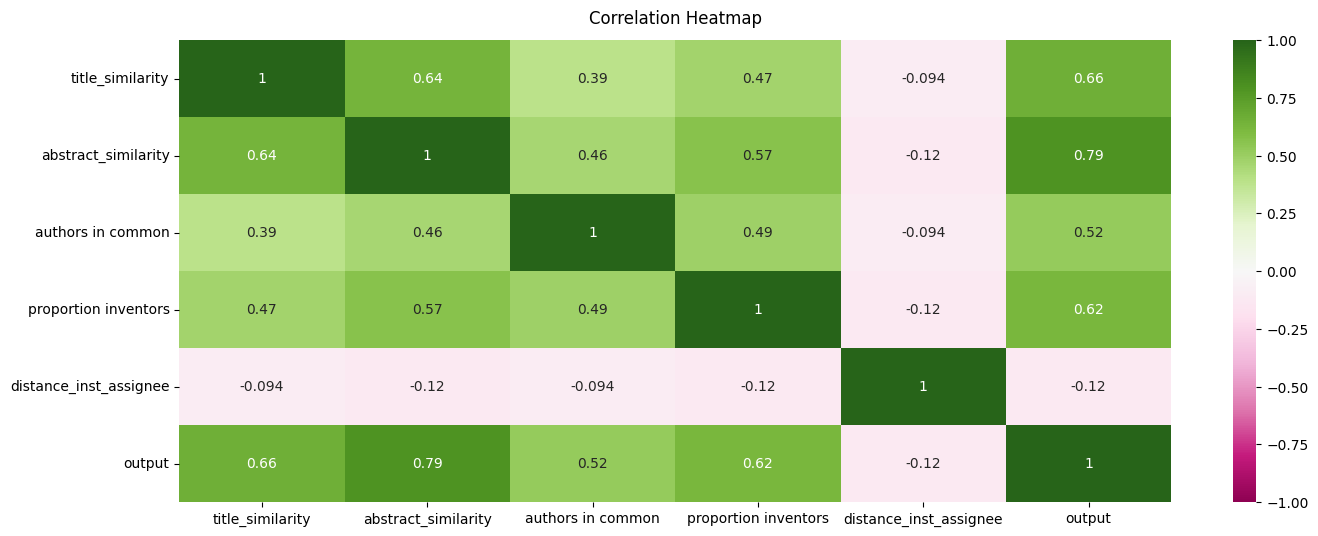

In [28]:
##correlation matrix

import matplotlib.pyplot as plt
import seaborn as sns

df = df[['title_similarity', 'abstract_similarity', 'authors in common',
       'proportion inventors', 'distance_inst_assignee',
         'output']]
df = df.sample(frac=1).reset_index(drop=True)
df = df.apply(pd.to_numeric , errors='coerce')
df = df.apply(pd.to_numeric , errors='coerce')

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True , center = 0 , cmap="PiYG")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Models

### Missing values

In [29]:
## replace missing values with mean value over the training set
mean = df["distance_inst_assignee"].mean()
df["distance_inst_assignee"] = [ mean if pd.isna(elem) == True else elem for elem in df["distance_inst_assignee"] ] 


### Training set

In [60]:
## training set: 80%, testing set: 20%

df = df.sample(frac=1).reset_index(drop=True)
X = df.drop(["output" ] , axis = 1)
y = df["output"]

#80% of the data from the training set while 20% form the testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Regression logistic

In [77]:
#run the logistic model

import statsmodels.formula.api as smf

training_set = X_train
training_set["output"] = y_train
training_set= training_set.rename(columns = { "proportion inventors" : "proportion_inventors" , "authors in common" : "authors_in_common" } )

#regression_model = smf.logit('output ~ title_similarity + abstract_similarity + authors_in_common + proportion_inventors + distance_inst_assignee  + front + body ' , data=training_set , missing='drop').fit()
regression_model = smf.logit('output ~ title_similarity + abstract_similarity + authors_in_common + proportion_inventors + distance_inst_assignee  ' , data=training_set , missing='drop').fit()

print(regression_model.summary())

Optimization terminated successfully.
         Current function value: 0.163279
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 output   No. Observations:                 5662
Model:                          Logit   Df Residuals:                     5656
Method:                           MLE   Df Model:                            5
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                  0.7644
Time:                        13:45:39   Log-Likelihood:                -924.49
converged:                       True   LL-Null:                       -3924.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -13.3933      0.413    -32.411      0.000     -14.203     -

In [78]:
#evaluate the logistic model on the testing set
test_set = X_test
test_set["output"] = y_test
test_set= test_set.rename(columns = { "proportion inventors" : "proportion_inventors" , "authors in common" : "authors_in_common" } )

y_pred = regression_model.predict(test_set).to_numpy()
y_test_log = test_set["output"]
## Baseline model:
y_baseline = 1- np.zeros((len(y_pred)))

print(" The accuracy of the baseline model on the test set is equal to" , accuracy(y_test_log,y_baseline))  
print(" The TPR of the logistic baseline model on the test set is equal to" , TPR(y_test_log,y_baseline))  
print(" The FPR of the logistic baseline model on the test set is equal to" , FPR(y_test_log,y_baseline))  


print(" ")
n = len(y_pred)
y_pred_log = [0]*n
for i in tqdm(range(n)) :
    if y_pred[i] >= 0.50 :
            y_pred_log[i] = 1
print(" The accuracy of the logistic regression method on the test set is equal to" , accuracy(y_test_log,y_pred_log))  
print(" The TPR of the logistic regression method on the test set is equal to" , TPR(y_test_log,y_pred_log))  
print(" The FPR of the logistic regression method on the test set is equal to" , FPR(y_test_log,y_pred_log))  

 The accuracy of the baseline model on the test set is equal to 0.4950564971751412
 The TPR of the logistic baseline model on the test set is equal to 1.0
 The FPR of the logistic baseline model on the test set is equal to 1.0
 


100%|██████████████████████████████████| 1416/1416 [00:00<00:00, 1956881.21it/s]

 The accuracy of the logistic regression method on the test set is equal to 0.9399717514124294
 The TPR of the logistic regression method on the test set is equal to 0.9429386590584878
 The FPR of the logistic regression method on the test set is equal to 0.06293706293706294


### Decision tree

In [79]:
X_train = X_train.drop(["output"] , axis = 1)
X_test = X_test.drop(["output"] , axis = 1)

/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_

Node count = 19


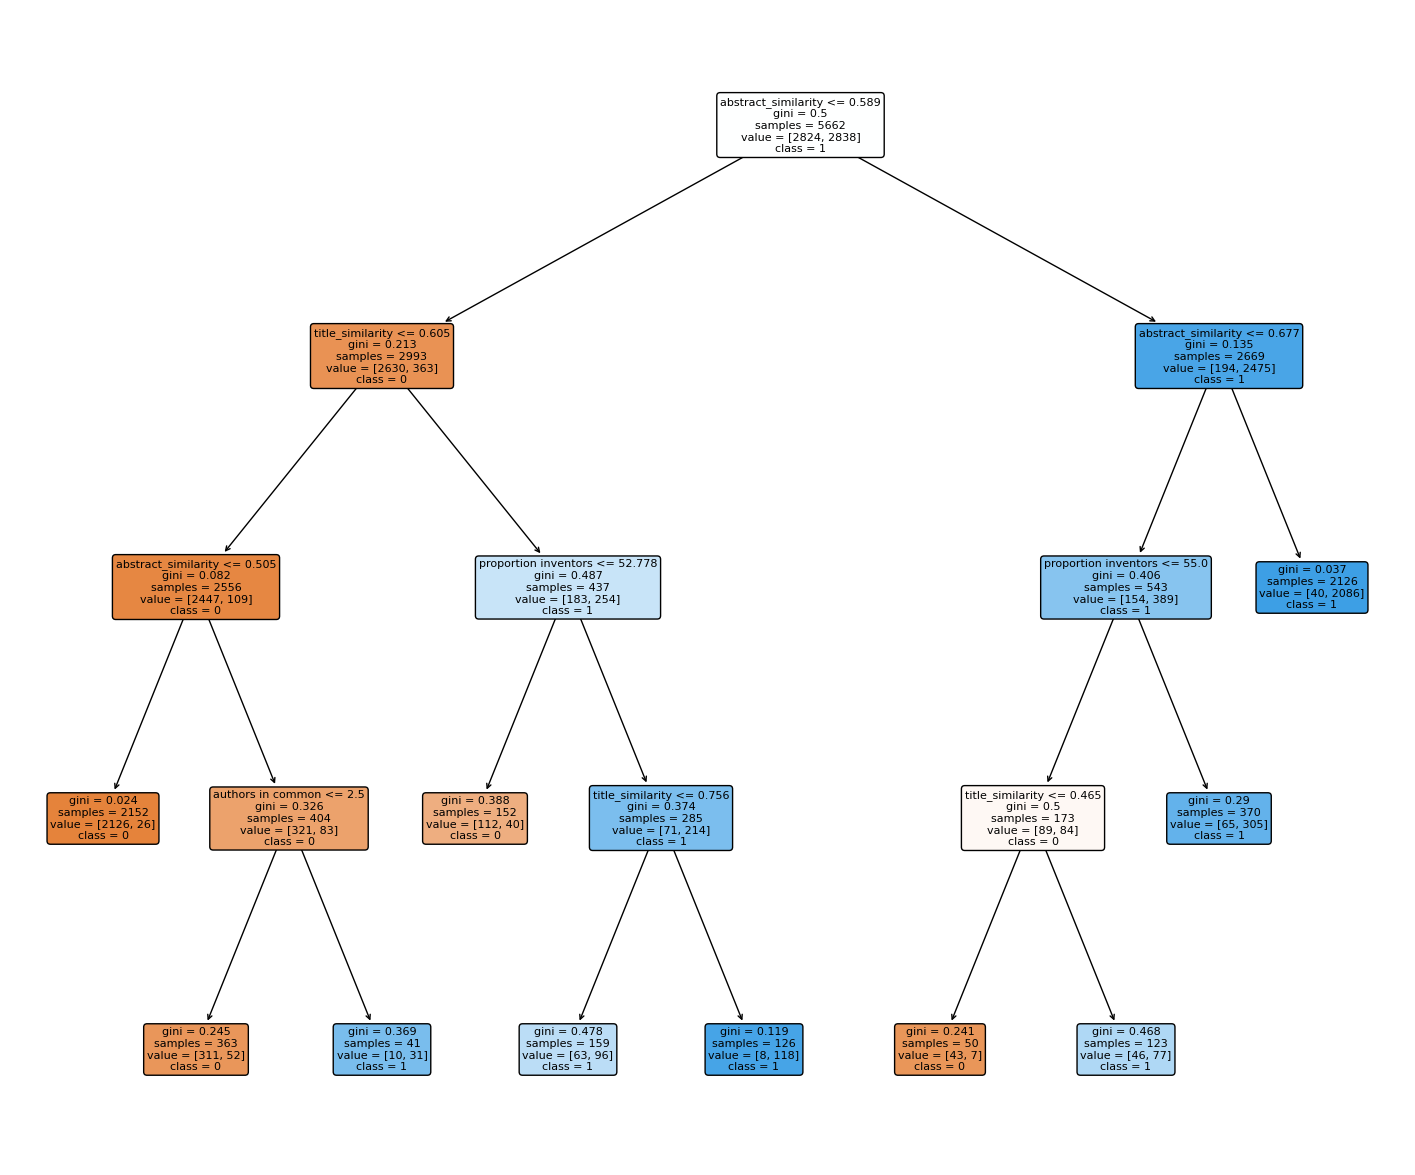

In [80]:
#run the decision tree model

from sklearn.tree import DecisionTreeClassifier


dtc = DecisionTreeClassifier(min_samples_leaf=8, 
                             ccp_alpha= 0.0015,
                             criterion = 'gini',
                             random_state = 88)

dtc = dtc.fit(X_train, y_train)

#below is the code for plotting the decision tree classifier and counting the number of nodes. 


import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(18,15))
plot_tree(dtc, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=8
         ) 
plt.show()

In [82]:
#evaluate the decision tree model on the testing set


y_pred = dtc.predict(X_test)
y_baseline = 1 - np.zeros((len(y_pred)))

print(" The accuracy of the baseline model on the test set is equal to" , accuracy(y_test,y_baseline))  
print(" The TPR of the logistic baseline model on the test set is equal to" , TPR(y_test,y_baseline))  
print(" The FPR of the logistic baseline model on the test set is equal to" , FPR(y_test,y_baseline))  


print( " ")
print(" The accuracy of the decision tree regression method on the test set is equal to" , accuracy(y_test,y_pred))  
print(" The TPR of the decision tree method on the test set is equal to" , TPR(y_test,y_pred))  
print(" The FPR of the decision tree method on the test set is equal to" , FPR(y_test,y_pred))  


 The accuracy of the baseline model on the test set is equal to 0.4950564971751412
 The TPR of the logistic baseline model on the test set is equal to 1.0
 The FPR of the logistic baseline model on the test set is equal to 1.0
 
 The accuracy of the decision tree regression method on the test set is equal to 0.9357344632768362
 The TPR of the decision tree method on the test set is equal to 0.9629101283880172
 The FPR of the decision tree method on the test set is equal to 0.09090909090909091


/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


### Random forest

In [ ]:
#run the random forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict_proba(X_test)


## Baseline model:
y_baseline = np.zeros((len(y_pred)))

print(" The accuracy of the baseline model on the test set is equal to" , accuracy(y_test,y_baseline))  
print(" The TPR of the logistic baseline model on the test set is equal to" , TPR(y_test,y_baseline))  
print(" The FPR of the logistic baseline model on the test set is equal to" , FPR(y_test,y_baseline))  

print(" ") 

n = len(y_pred)
y_pred_rf = [0]*n
for i in range(n) :
    if y_pred[i][1] >= 0.7 :
            y_pred_rf[i] = 1

print(" The accuracy of the random forest method on the test set is equal to" , accuracy(y_test,y_pred_rf))  
print(" The TPR of the random forest method on the test set is equal to" , TPR(y_test,y_pred_rf))  
print(" The FPR of the random forest method on the test set is equal to" , FPR(y_test,y_pred_rf))  

In [ ]:
thresholds = [ 0.7 , 0.8 , 0.9 , 0.99] 
dic_results = {}


for threshold in thresholds:
    
    dic_results[threshold] = {}
    
    
    y_pred = rf.predict_proba(X_test)

    n = len(y_pred)
    y_pred_rf = [0]*n
    for i in range(n) :
        if y_pred[i][1] >= threshold :
                y_pred_rf[i] = 1
                
    dic_results[threshold]["precision"] = precision(y_test,y_pred_rf)*100
    
    dic_results[threshold]["f1"] = 100*2*( precision(y_test,y_pred_rf) * recall(y_test,y_pred_rf) ) / ( precision(y_test,y_pred_rf) + recall(y_test,y_pred_rf))
    
    dic_results[threshold]["recall"] = recall(y_test,y_pred_rf)*100

    print(" The f1 of the random forest method on the test set is equal to" , 2*( precision(y_test,y_pred_rf) * recall(y_test,y_pred_rf) ) / ( precision(y_test,y_pred_rf) + recall(y_test,y_pred_rf) )) 
    print(" The precision of the random forest method on the test set is equal to" , precision(y_test,y_pred_rf))  
    print(" The recall of the random forest method on the test set is equal to" , recall(y_test,y_pred_rf)) 
   
    print(" ")
    print(" ")

In [67]:
pd.DataFrame(dic_results).rename( columns = {  0.2 : "PPP if prediction > 0.2" ,  0.6 : "PPP if prediction > 0.6" ,  0.9 : "PPP if prediction > 0.9" ,  0.99: "PPP if prediction > 0.99" } )
                                                                                 

,0.7,0.8,PPP if prediction > 0.9,PPP if prediction > 0.99
precision,99.254844,99.685039,100.000000,100.000000
f1,95.965418,93.639053,88.664596,76.804124
recall,92.887029,88.284519,79.637378,62.343096


### Model analysis

In [87]:
# Get numerical feature importances


#importances = sorted(list(rf.feature_importances_) , reverse = True)
importances = list(rf.feature_importances_)


feature_list = list(X_test.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#feature_importances = feature_importances
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: abstract_similarity  Importance: 0.5282
Variable: title_similarity     Importance: 0.2426
Variable: proportion inventors Importance: 0.1219
Variable: authors in common    Importance: 0.0576
Variable: distance_inst_assignee Importance: 0.0496


[None, None, None, None, None]

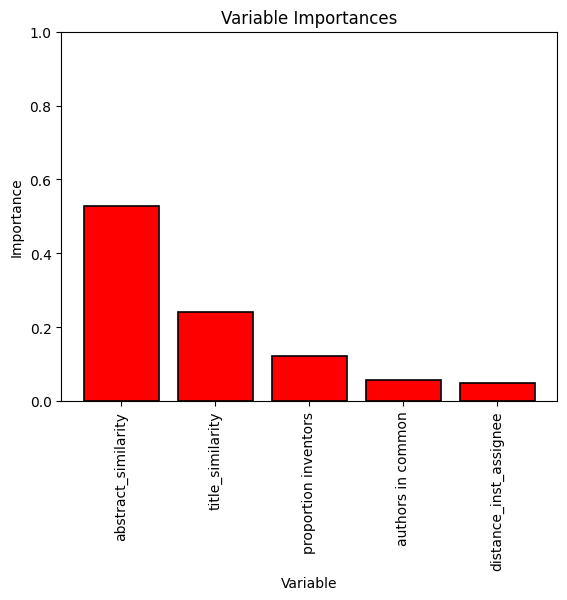

In [88]:
#plot the feature importance 

x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, sorted(importances , reverse = True), orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2 )
# Tick labels for x axis
plt.xticks(x_values, list(np.array(feature_importances)[:,0]), rotation='vertical')
plt.ylim((0,1))
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

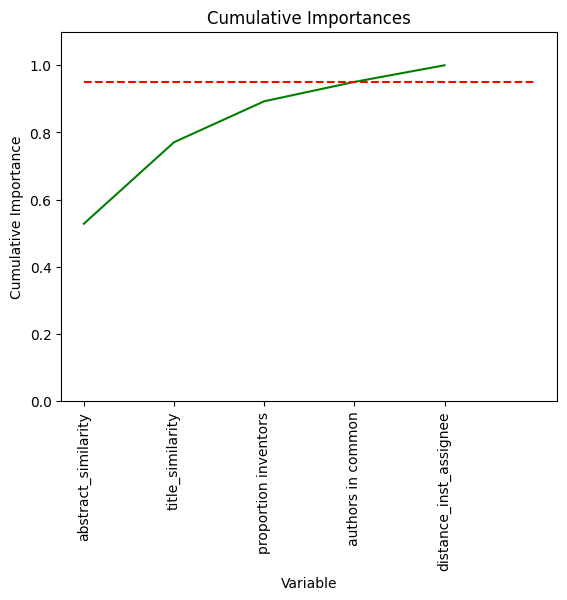

In [89]:
#plot the feature importance 


# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
plt.ylim((0,1.1))
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

### Distribution results

Text(0.5, 9.444444444444438, 'Prediction')

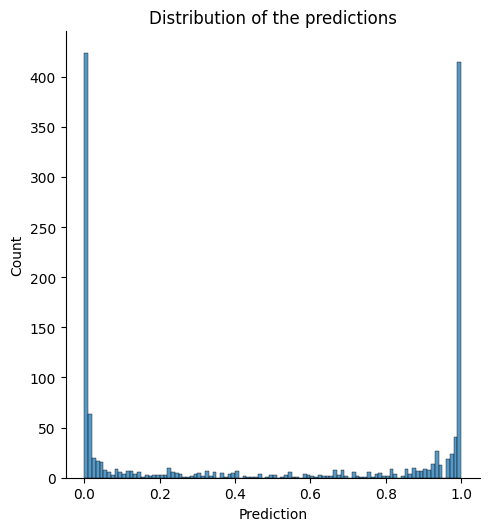

In [90]:
#plot the distribution of the results

sns.displot(y_pred[:,1] , binwidth=0.01 )
plt.title("Distribution of the predictions")
plt.xlabel("Prediction")

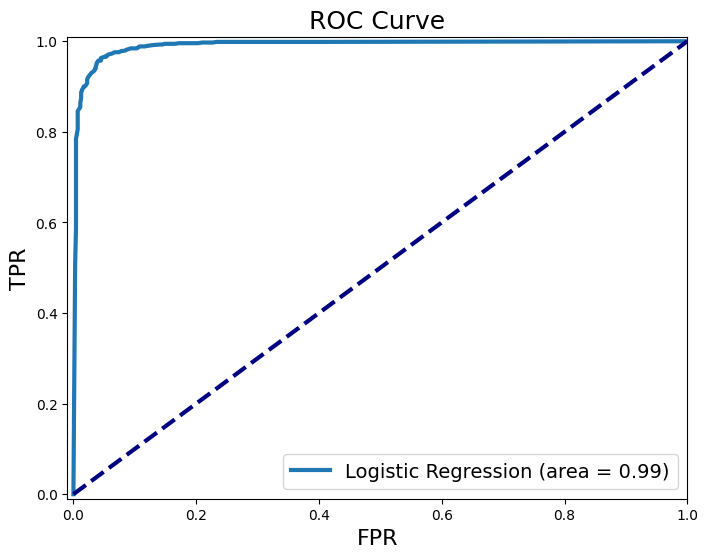

In [91]:
#plot the ROC curve (TPR as a function of the FPR)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## Categories 

Prediction > 0.99 --> category 4   
Prediction > 0.9 --> category 3  
Prediction > 0.8 --> category 2  
Prediction > 0.7 --> category 1  
Others: 0 

In [117]:
df_tot["PPP_score"] = [ 4 if elem > 0.99 else 3 if elem > 0.9 else 2 if elem > 0.8 else 1 if elem > 0.7 else 0 for elem in df_tot["prediction"] ] 


# Model evaluation - golden dataset

## Golden dataset features

In [126]:
## load golden dataset of PPPs (manually checked)
df_matt = pd.read_csv(main_path + "PPPs/predictive_model/mag_patent_ppp_Henry.csv" , encoding= 'unicode_escape')

In [129]:
citations = df_matt[[ "Patent" , "Magid" ]].to_numpy()

count = 0

def get_training_set(workers, i):
     """
    This function retrieves and compares the titles and abstracts of patents and papers from a PostgreSQL database to create a training set for a machine learning model.

    Parameters:
    - workers (int): The number of worker processes to use for parallel processing. 
    - i (int): The starting index for the citations to be processed.

    Returns:
    - dic_similarity (dict): A dictionary containing the similarity scores between the titles and abstracts of patents and papers, as well as other relevant information such as publication dates and author names.

    Notes: 
    The function first establishes a connection with a PostgreSQL database using the psycopg2 library. It then retrieves a list of citations to be processed, with each citation consisting of a patent ID and a paper ID. The function loops through the list of citations in batches of size 'workers', with the starting index being 'i'.

    For each citation, the function retrieves the encoded titles and abstracts of the patent and the paper from the PostgreSQL database. If the abstracts of both the patent and the paper are available, the function calculates the cosine similarity between the titles and abstracts of the patent and the paper using the cosine_similarity2() function. The function also retrieves other relevant information such as the publication dates, author names, and assignee names of the patent and the paper.

    The function stores the similarity scores and other relevant information in a dictionary called 'dic_similarity', with the keys being the concatenation of the patent ID and the paper ID.

    The function returns the 'dic_similarity' dictionary, which can be used as a training set for a machine learning model to predict the similarity between patents and papers.
    """

    #establishing the connection with the database 
    conn = psycopg2.connect("user=" + user + " password=" + password) 
    cursor = conn.cursor()
    
    dic_similarity = {}
    
    
    list_index = [ k for k in range(i,len(citations), workers) ] 
    count = 0
        
    for k in list_index:
        elem = citations[k]
        
        dic_comparison = {}
        dic_comparison["PV"] = {}
        dic_comparison["OA"] = {}
    
        count += 1
        
        dic_similarity1 = {}
        
        if elem[0][:3] == "US-":
    
            patent_id = elem[0].split("-")[1]
            dic_comparison["PV"][patent_id] = {}
            
            text = """ SELECT  pe.encoded_title , pe.encoded_abstract
                       FROM encoded_patents_PatentsView AS pe
                       WHERE pe.patent_id = '"""+ patent_id + """';"""
            
            cursor.execute(text)
            res = cursor.fetchall()
    
            
            for line in res:
                if line[0] != 0:
                    dic_comparison["PV"][patent_id]["title"] = clean_encoding(line[0])
                if line[1] != 0:
                    dic_comparison["PV"][patent_id]["abstract"] = clean_encoding(line[1])
                    
                    
                    
            work_id = "W" + str(elem[1])
            dic_comparison["OA"][work_id] = {}
            
            text = """ SELECT  we.encoded_title , we.encoded_abstract 
                        FROM encoded_works_OpenAlex AS we 
                        WHERE we.work_id = '"""+ str(work_id) +"""';"""
    
    
            cursor.execute(text)
            res = cursor.fetchall()
            
            encoded_title_OA = None
            encoded_abstract_OA = None
            for line in res:
    
                if line[0] != None and line[0] != '':
                    dic_comparison["OA"][work_id]["title"] = clean_encoding(line[0])
    
    
                if line[1] != None and line[1] != '':
                    dic_comparison["OA"][work_id]["abstract"] = clean_encoding(line[1])
    
                    
            if  "title" not in dic_comparison["OA"][work_id]:
                dic_comparison["OA"][work_id]["title"]  = None
            if  "abstract" not in dic_comparison["OA"][work_id]:
                dic_comparison["OA"][work_id]["abstract"]  = None
                
    
            if dic_comparison["OA"][work_id]["abstract"] != None and dic_comparison["PV"][patent_id]["abstract"] != None:
                
                dic_similarity1["US-" + patent_id + " " + work_id] = {}
                
        
                encoded_title_PV = dic_comparison["PV"][patent_id]["title"]
                encoded_abstract_PV = dic_comparison["PV"][patent_id]["abstract"]
        
                encoded_title_OA = dic_comparison["OA"][work_id]["title"]
                encoded_abstract_OA = dic_comparison["OA"][work_id]["abstract"]
        
        
                if encoded_title_PV != None and encoded_title_OA != None:
                    dic_similarity1["US-" + patent_id + " " + work_id]["title_similarity"] = cosine_similarity2(encoded_title_PV , encoded_title_OA)
                else:
                    dic_similarity1["US-" + patent_id + " " + work_id]["title_similarity"] = None
        
                if encoded_abstract_OA != None and encoded_abstract_PV != None and encoded_abstract_PV != [] :
                    dic_similarity1["US-" + patent_id + " " + work_id]["abstract_similarity"] = cosine_similarity2(encoded_abstract_PV , encoded_abstract_OA)
                else:
                    dic_similarity1["US-" + patent_id + " " + work_id]["abstract_similarity"] = None
                    
                    
                                   
                    
        
                text = """ SELECT  p.patent_date , ap.filing_date , string_agg( CONCAT(disambig_inventor_name_first ,  ' '  , disambig_inventor_name_last),  '#') , p.patent_title , p.patent_abstract , string_agg( concat(a.disambig_assignee_organization  , '%' , l.longitude , '%' , l.latitude ) ,   '#') 
                            FROM patents_PatentsView AS p 
                            LEFT JOIN applications_PatentsView AS ap ON ap.patent_id = '"""+ patent_id + """'
                            LEFT JOIN inventors_PatentsView AS i ON i.patent_id =  '"""+ patent_id + """'
                            LEFT JOIN assignees_PatentsView AS a ON a.patent_id =  '"""+ patent_id + """'
                            LEFT JOIN locations_PatentsView AS l ON a.location_id = l.location_id
                            WHERE p.patent_id = '"""+ patent_id + """'
                            GROUP BY  p.patent_date , ap.filing_date , p.patent_title , p.patent_abstract;"""
                            
        
                cursor.execute(text)
                res = cursor.fetchall()
        
                for line in res:
        
                    dic_comparison["PV"][patent_id]["patent_date"] = line[0]
                    dic_comparison["PV"][patent_id]["filing_date"] = line[1]
                    dic_comparison["PV"][patent_id]["co_inventors"] = [ normalize(elem) for elem in set(line[2].split("#")) ] 
                    dic_comparison["PV"][patent_id]["title_abstract"] = line[3] + ". " + line[4]
                    if line[5] != None:
                        locations = [ elem.split("%") for elem in set(line[5].split("#"))] 
                        dic_comparison["PV"][patent_id]["assignees"] = ", ".join([ elem[0].replace("\"" , "") for elem in locations ] )
                        dic_comparison["PV"][patent_id]["coordinates"] = [ (float(elem[1]) , float(elem[2]))for elem in locations if elem[1] != '' and elem[1] != None ]
                    else:
                        dic_comparison["PV"][patent_id]["assignees"] = None
                        dic_comparison["PV"][patent_id]["coordinates"] = []
                
        
        
                text = """ SELECT  w.title , w.abstract, w.publication_date , w.type , string_agg(a.display_name , '#') , string_agg(wa.institution_name , ', ') , string_agg(wa.institution_id , '#')
                            FROM works_authors_OpenAlex AS wa
                            LEFT JOIN works_OpenAlex AS w ON w.work_id = wa.work_id 
                            LEFT JOIN authors_OpenAlex AS a ON wa.author_id = a.author_id
                            WHERE wa.work_id ='""" + str(work_id) +"""'
                            group by w.title , w.abstract, w.publication_date , w.type ;"""
        
        
        
        
                cursor.execute(text)
                res = cursor.fetchall()
                
                encoded_title_OA = None
                encoded_abstract_OA = None
                for line in res:
        
                    dic_comparison["OA"][work_id]["publication_date"] = None
                    if line[2] != None:
                        dic_comparison["OA"][work_id]["publication_date"] = line[2]
        
                    if line[3] != None:
                        dic_comparison["OA"][work_id]["type"] = line[3]
        
                    dic_comparison["OA"][work_id]["co_authors"] = [ normalize(elem) for elem in set(line[4].split("#") )] 
        
                    if line[0] != None:
                        dic_comparison["OA"][work_id]["title_abstract"] = line[0] + ". " + line[1]
        
                    dic_comparison["OA"][work_id]["institutions"] = line[5]
                    if line[6] != None:
                        inst_ids = line[6].split("#")
                    else:
                        inst_ids = []
                    dic_comparison["OA"][work_id]["coordinates"] = []
                    
                    for inst_id in inst_ids:
                        if inst_id in dic_institutions:
                            dic_comparison["OA"][work_id]["coordinates"].append((dic_institutions[inst_id]["longitude"] , dic_institutions[inst_id]["latitude"]))
                                         
                        
                if "publication_date" in dic_comparison["OA"][work_id] and dic_comparison["OA"][work_id]["publication_date"] != None:
        
                    dic_similarity1["US-" + patent_id + " " + work_id]["difference_patent_app_paper"] =  dic_comparison["PV"][patent_id]["filing_date"] - dic_comparison["OA"][work_id]["publication_date"]
        
                    dic_similarity["US-" + patent_id + " " + work_id] = dic_similarity1["US-" + patent_id + " " + work_id]
        
                    encoded_title_PV = dic_comparison["PV"][patent_id]["title"]
                    encoded_abstract_PV = dic_comparison["PV"][patent_id]["abstract"]
        
                    encoded_title_OA = dic_comparison["OA"][work_id]["title"]
                    encoded_abstract_OA = dic_comparison["OA"][work_id]["abstract"]
        
        
                    if encoded_title_PV != None and encoded_title_OA != None:
                        dic_similarity["US-" + patent_id + " " + work_id]["title_similarity"] = cosine_similarity2(encoded_title_PV , encoded_title_OA)
                    else:
                        dic_similarity["US-" + patent_id + " " + work_id]["title_similarity"] = None
        
                    if encoded_abstract_OA != None and encoded_abstract_PV != None and encoded_abstract_PV != [] :
                        dic_similarity["US-" + patent_id + " " + work_id]["abstract_similarity"] = cosine_similarity2(encoded_abstract_PV , encoded_abstract_OA)
                    else:
                        dic_similarity["US-" + patent_id + " " + work_id]["abstract_similarity"] = None
        
                    dic_similarity["US-" + patent_id + " " + work_id]["difference_patent_grant_paper"] =   dic_comparison["PV"][patent_id]["patent_date"] - dic_comparison["OA"][work_id]["publication_date"]
                    dic_similarity["US-" + patent_id + " " + work_id]["paper type"] = dic_comparison["OA"][work_id]["type"]
                    dic_similarity["US-" + patent_id + " " + work_id]["authors in common"] = number_of_in_common_authors(dic_comparison["PV"][patent_id]["co_inventors"] , dic_comparison["OA"][work_id]["co_authors"])[0]
                    dic_similarity["US-" + patent_id + " " + work_id]["numbers authors"] = len(dic_comparison["OA"][work_id]["co_authors"])
                    dic_similarity["US-" + patent_id+ " " + work_id]["numbers inventors"] = len(dic_comparison["PV"][patent_id]["co_inventors"]) 
        
                    dic_similarity["US-" + patent_id + " " + work_id]["proportion inventors"] = 100*number_of_in_common_authors(dic_comparison["PV"][patent_id]["co_inventors"] , dic_comparison["OA"][work_id]["co_authors"])[0] / len(dic_comparison["PV"][patent_id]["co_inventors"])
                    dic_similarity["US-" + patent_id + " " + work_id]["paper_institution"] = dic_comparison["OA"][work_id]["institutions"]
                    dic_similarity["US-" + patent_id + " " + work_id]["patent_assignee"] = dic_comparison["PV"][patent_id]["assignees"]
                    dic_similarity["US-" + patent_id + " " + work_id]["distance_inst_assignee"] = distance_assignees(dic_comparison["PV"][patent_id]["coordinates"], dic_comparison["OA"][work_id]["coordinates"] )
        
        
                    text1 = clean_string_stop_words(dic_comparison["OA"][work_id]["title_abstract"])[:1000]
                    text2 = clean_string_stop_words(dic_comparison["PV"][patent_id]["title_abstract"])[:1000]
        
                    plagiarism  = dmp.diff_main(text1, text2 , True)
        
                    plagiarism = [ elem for elem in plagiarism if elem[0] == 0] 
                    plagiarism = sorted(plagiarism, key = lambda val: len(val[1]) , reverse = True)[:5]
                    
                    dic_similarity["US-" + patent_id + " " + work_id]["common_strings"] = [ elem[1] for elem in plagiarism[:5]]
        
                    dic_similarity["US-" + patent_id + " " + work_id]["plagiarism_group_words_1"] = sum([ len(elem[1].split()) for elem in plagiarism[:1]])
        
                    dic_similarity["US-" + patent_id + " " + work_id]["plagiarism_group_words_3"] = sum([ len(elem[1].split()) for elem in plagiarism[:3]])
        
                    dic_similarity["US-" + patent_id + " " + work_id]["plagiarism_group_words_5"] = sum([ len(elem[1].split()) for elem in plagiarism])
                    
                    dic_similarity["US-" + patent_id + " " + work_id]["plagiarism_percentage"] = 100*dic_similarity["US-" + patent_id+ " " + work_id]["plagiarism_group_words_5"] / ( len(text1.split()) + len(text2.split()) - dic_similarity["US-" + patent_id+ " " + work_id]["plagiarism_group_words_5"] ) 
        
    return dic_similarity

In [130]:
##get the abstracts of the papers published in 'year'
workers = 24

p = Pool(processes=workers)
func = partial(get_training_set,workers)
abstracts = p.map(func, [ i  for i in range(workers)])
p.close()

In [131]:
## concatenate output
dic_similarity = {}

for dic in abstracts:
    dic_similarity = { **dic_similarity , **dic }
print(len(dic_similarity))

854


In [187]:
## save golden dataset features 
table = pd.DataFrame(dic_similarity).T.sort_values("plagiarism_group_words_1" , ascending = False)
table.to_csv(main_path + "PPPs/predictive_model/golden_dataset_features.tsv", sep = "\t")

## Comparison Golden dataset 

In [3]:
## load manually classified PPPs (golden dataset)

df_golden = pd.read_csv(main_path + "PPPs/predictive_model/mag_patent_ppp_Henry.csv" , encoding= 'unicode_escape' , index_col = 0)
df_golden['Magid'] = df_golden['Magid'].astype("int")
df_golden['Patent'] = df_golden['Patent'].astype("str")
df_golden = df_golden.rename( columns = {'Patent-paper pair\n(Confidence level 0 to 5)' : 'Henry_score'})

In [4]:
## load features correponding to the golden dataset

golden_pred = pd.read_csv(main_path + "PPPs/predictive_model/golden_dataset_features.tsv", delimiter = "\t", index_col = 0)
golden_pred['Magid'] = [ int(elem.split()[1][1:]) for elem in golden_pred.index ] 
golden_pred['Patent'] = [ str(elem.split()[0]) for elem in golden_pred.index ] 
golden_pred

,title_similarity,abstract_similarity,difference_patent_app_paper,difference_patent_grant_paper,paper type,authors in common,numbers authors,numbers inventors,proportion inventors,paper_institution,patent_assignee,distance_inst_assignee,common_strings,plagiarism_group_words_1,plagiarism_group_words_3,plagiarism_group_words_5,plagiarism_percentage,Magid,Patent
US-4479932 W2018950212,0.748480,0.911992,"151 days, 0:00:00","1047 days, 0:00:00",article,1,3,1,100.0,NaN,"University of Florida Foundation, Incorporated",3.031509,[' brain elimination general circulations acce...,15,25,28,24.561404,2018950212,US-4479932
US-10055875 W2070827315,1.000000,0.814810,"361 days, 0:00:00","2584 days, 0:00:00",article,2,2,2,100.0,NaN,NVIDIA Corporation,8598.776817,[' water arbitrary terrain represented without...,12,33,44,28.947368,2070827315,US-10055875
US-4812995 W2134876121,0.812860,0.881345,"-227 days, 0:00:00","438 days, 0:00:00",article,1,2,2,50.0,NaN,NaN,NaN,['one model assumes phases unfaulted model ass...,12,31,40,20.304569,2134876121,US-4812995
US-6681202 W2139483503,0.355162,0.819303,"-724 days, 0:00:00","439 days, 0:00:00",article,2,3,2,100.0,NaN,KONINKLIJKE PHILIPS ELECTRONICS NV,3.099556,[' band hz speech signal obtain extended band ...,10,22,32,32.323232,2139483503,US-6681202
US-6020122 W1989812564,0.834434,0.609221,"67 days, 0:00:00","1767 days, 0:00:00",article,2,9,4,50.0,NaN,ABBOTT LABORATORIES,7.093860,['hepatitis c virus second envelope hcv e glyc...,8,12,15,8.021390,1989812564,US-6020122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-6756592 W1993271675,0.474502,0.235677,"31 days, 0:00:00","1094 days, 0:00:00",article,1,6,2,50.0,NaN,University Corporation for Atmospheric Research,NaN,"[' dimensional ', 'lation ', 'lation ', 'ation...",1,3,5,2.976190,1993271675,US-6756592
US-9546102 W1978562700,0.623228,0.447438,"226 days, 0:00:00","1477 days, 0:00:00",article,1,6,1,100.0,NaN,GAVISH-GALILEE BIO APPLICATIONS LTD.,1.349611,"[' nanocomposites ', ' pretreatment ', ' waste...",1,3,5,3.875969,1978562700,US-9546102
US-5017342 W2005806320,0.449486,0.128899,"517 days, 0:00:00","1601 days, 0:00:00",article,0,4,3,0.0,NaN,Ortho Diagnostic Systems Inc.,17.857549,"['mple ', 'ctio', 'ing ', 'sis ', 's s']",1,3,6,4.761905,2005806320,US-5017342
US-6794197 W1974877827,0.386897,0.306133,"325 days, 0:00:00","1674 days, 0:00:00",article,2,8,2,100.0,NaN,"Zyomyx, Inc.",27.695577,"[' micro', 'micro', 'ing ', 'y pa', 'ect']",1,3,6,4.511278,1974877827,US-6794197


In [5]:
## use the random forest on the golden dataset

golden_pred = golden_pred[golden_pred["title_similarity"].notnull()]
golden_pred = golden_pred.merge(df_golden[['Magid','Patent','Henry_score']], on=['Magid','Patent'], how='inner')

mean = golden_pred["distance_inst_assignee"].mean()
golden_pred["distance_inst_assignee"] = [ mean if pd.isna(elem) == True else elem for elem in golden_pred["distance_inst_assignee"] ] 

## import predictive model trained using self-plagiarism
import pickle
with open(main_path + 'PPPs/random_forest_PPPs.pkl','rb') as f:
    rf = pickle.load(f)
 

#df = df.sample(frac=1).reset_index(drop=True)
X = golden_pred.drop([
       'difference_patent_app_paper', 'difference_patent_grant_paper',
       'paper type', 
       'paper_institution', 'patent_assignee', 
       'common_strings', 'plagiarism_group_words_1',
       'plagiarism_group_words_3', 'plagiarism_group_words_5',
       'plagiarism_percentage' , 'numbers inventors' , 'numbers authors' , 'Henry_score', "Magid","Patent"] , axis = 1)



y_pred = rf.predict_proba(X)
golden_pred["prediction"] = np.array(y_pred)[:,1]


In [14]:
## classify the golden dataset into 5 categories 
golden_pred["PPP_score"] = [ 4 if elem > 0.99 else 3 if elem > 0.9 else 2 if elem > 0.8 else 1 if elem > 0.7 else 0 for elem in golden_pred["prediction"] ] 


In [16]:
dic_comp = { 0: { k : 0 for k in range(5) } ,
           1 : { k :0 for k in range(5) } ,
           2 : { k :0 for k in range(5) } ,
           3: { k :0 for k in range(5) },
           4: { k :0 for k in range(5) }}


for elem in golden_pred.index:
    emma_score = int(golden_pred["PPP_score"][elem])
    if pd.notnull(golden_pred["Henry_score"][elem]):
        henry_score = int(golden_pred["Henry_score"][elem])
        if emma_score not in dic_comp:
            dic_comp[emma_score] = {}
        if henry_score not in dic_comp[emma_score]:
            dic_comp[emma_score][henry_score] = 0
        dic_comp[emma_score][henry_score] += 1
    

           

In [19]:
pd.DataFrame(dic_comp).T.rename( index = {  0 : "0 <= prediction <= 0.7" ,  1 : "0.7 < prediction <= 0.8" ,  2 : "0.8 < prediction <= 0.9"  ,  3 : "0.9 < prediction <= 0.99", 4 : "0.99 < prediction <= 1"})






,0,1,2,3,4,5
0 <= prediction <= 0.7,160,158,62,151,38,133
0.7 < prediction <= 0.8,4,4,1,4,4,7
0.8 < prediction <= 0.9,0,2,2,3,3,13
0.9 < prediction <= 0.99,0,1,0,6,2,17
0.99 < prediction <= 1,0,0,0,2,0,11


In [411]:
patents = list(set(df_category["patent_id"].tolist()))

mydb = mysql.connector.connect(user='openalex', password='_OpenAlex_',
                                          host='haas-hpc11',
                                          database='openalex')

mycursor = mydb.cursor()


for patent_id in tqdm(patents):
    
    dic_patents[patent_id]["type"] = []
    dic_patents[patent_id]["assignee"] = []

    
    patent = patent_id.split("-")[1]

    text = """SELECT a.psn_sector , a.han_name
              FROM patent_number_Patstat AS n
              JOIN persons_patents_Patstat AS p ON p.pat_publn_id = n.pat_publn_id
              JOIN assignees_types_Patstat AS a ON a.person_id = p.person_id
              WHERE n.publn_nr = '""" + patent + """' AND n.publn_auth = 'US'
              ;"""

    mycursor.execute(text)  
    res = mycursor.fetchall()
    
        
    for line in res:
        
        if line[0] != '' and line[0] != "INDIVIDUAL" and line[0] != "UNKNOWN":
            
            dic_patents[patent_id]["type"].append(line[0])
            dic_patents[patent_id]["assignee"].append(line[1])
        
        
        
        
    
    
    

mydb.close()


100%|██████████| 83414/83414 [01:12<00:00, 1151.31it/s]


In [447]:
count = 0 
dic_types = { "education" : { "education" : 0 , "company" : 0 ,"mixed type" : 0, "government" : 0} ,
             "company" :  { "education" : 0 , "company" : 0 ,"mixed type" : 0, "government" : 0} ,
             "mixed type" :  { "education" : 0 , "company" : 0 , "mixed type" : 0, "government" : 0    },
             "government" :  { "education" : 0 , "company" : 0 , "mixed type" : 0,  "government" : 0 }
            }

for elem in dic_PPPs_types:
    paper_type = dic_PPPs_types[elem]["paper_type"]
    patent_type = dic_PPPs_types[elem]["patent_type"]
    

    if paper_type in dic_types and patent_type in dic_types[paper_type]:
        dic_types[paper_type][patent_type] += 1
    else:
        count += 1
    

    
print(count)   

22221


In [448]:
pd.DataFrame(dic_types).T

,education,company,mixed type,government
education,27270,10924,2727,3810
company,56,7425,86,74
mixed type,2666,5091,1394,1522
government,435,703,312,2251
